## Other Fun Features

Some other features that are included in the $\texttt{stella}$ package include finding rotation periods and fitting flares with a simple analytic model to extract parameters such as the equivalent duration. Here, we will go through each of these additional modules.

In [1]:
import os, sys
sys.path.insert(1, '/Users/arcticfox/Documents/GitHub/stella/')
import stella
import numpy as np
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt

plt.rcParams['font.size'] = 20

First thing's first: we need a light curve! We're going to use the same one that has been used in the previous demonstrations.

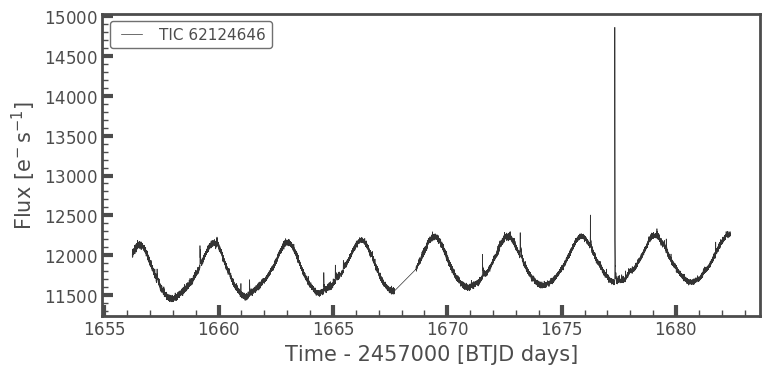

In [2]:
from lightkurve.search import search_lightcurvefile
lk = search_lightcurvefile(target='tic62124646', mission='TESS')
lk = lk.download().PDCSAP_FLUX
lk.plot()
lk = lk.remove_nans()

### 1.1 Measuring Rotation Periods

To measure the rotation period of a light curve, you need the following information: a target ID (can be anything you want), a time array, a flux array, and a flux error array. These can all be retrieved from the $\texttt{lightkurve}$ object. Then, you initialize the class $\texttt{stella.MeasureProt}$.

In [5]:
mProt = stella.MeasureProt([lk.targetid], [lk.time], [lk.flux], [lk.flux_err])

The rotation measurement tool used in this class is a Lomb-Scargle Periodogram. You have the option the set the minimum frequency (minf=1/12.5) and maximum frequency (maxf=1/0.1) that the periodogram searches over. You can also set the samples per peak (spp=50). The default values are noted in parentheses.

In [6]:
mProt.run_LS()

Finding most likely periods: 100%|██████████| 1/1 [00:00<00:00, 22.08it/s]


Calling this will create an $\texttt{astropy.table.Table}$ attribute with some metrics about the rotation period measured in that light curve. The columns in this table include:
- Target_ID: the ID for that light curve.
- period_days: the period as measured in the first orbit.
- secondary_period_days: the period as measured in the second orbit.
- gauss_width: the width of a best-fit Gaussian to the most likely period.
- max_power: the power of the periodogram at the most likely period.
- orbit_flag: a combined flag per orbit (0 = reliable measurement).
- oflag1: period flag for the first orbit (0 = reliable measurement).
- oflag2: period flag for the first orbit (0 = reliable measurement).
- Flags: Defines a flag based on all observations of the given target. This mainly applies to stars observed in multiple sectors, otherwise it is the same value as the orbit_flag (0 = reliable measurement).
- avg_period_days: the average most likely period for that target. This is averaged over multiple sectors when available.
    
Note that by fitting to each orbit, we are limiting the period search space to relatively short rotation periods.

In [8]:
mProt.LS_results

Target_ID,period_days,secondary_period_days,gauss_width,max_power,secondary_max_power,orbit_flag,oflag1,oflag2,Flags,avg_period_days
int64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64
62124646,3.2296791476459177,3.2163622471188593,0.3318830536516107,0.9481391092541238,0.19343615022157237,0.0,0.0,0.0,0,3.2296791476459177


For this star, we find a period of 3.23 days. We can fold over this period in $\texttt{lightkurve}$ to see if this period is found in the light curve:

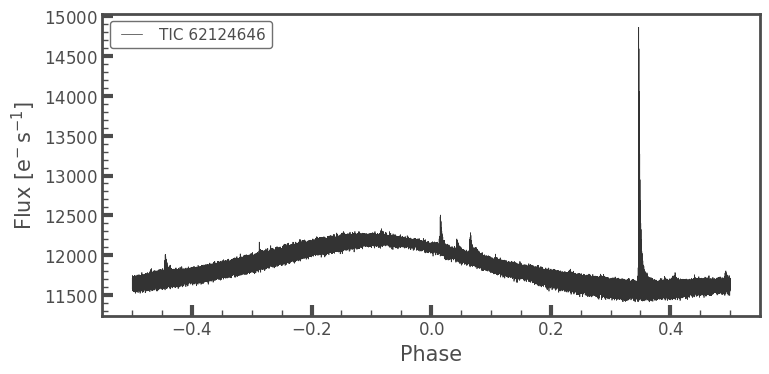

In [9]:
lk.fold(mProt.LS_results['avg_period_days'].data[0]).plot()

That looks nice! (And so do those flares!!)